In [55]:
import datetime
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd

import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.coordinates import frames

import SolAster
import SolAster.tools.rvs as rvs
import SolAster.tools.calculation_funcs as sfuncs
import SolAster.tools.lbc_funcs as lbfuncs
import SolAster.tools.coord_funcs as ctfuncs
import SolAster.tools.utilities as utils
from SolAster.tools.settings import *
from SolAster.tools.plotting_funcs import hmi_plot

Basic Set-Up

In [127]:
# name of csv file to store calculations
csv_name = 'timeseries'

# create file names
current_position = Path().resolve()
csv_file = os.path.join(current_position,"products/"+csv_name+'.csv')
bad_dates_csv = os.path.join(current_position,"products/"+csv_name+'_bad_dates.csv')

# List of header strings
row_contents = ['date_obs', 'date_jd', 'v_quiet', 'v_disc', 'v_phot', 'v_conv', 'f_bright', 'f_spot', 'f', 'Bobs',
                'vphot_bright', 'vphot_spot', 'f_small', 'f_large', 'f_network', 'f_plage', 'f_nonconv',
                'quiet_flux', 'ar_flux', 'conv_flux', 'pol_flux', 'pol_conv_flux', 'vconv_quiet', 'vconv_large',
                'vconv_small']

df = pd.DataFrame({i: [] for i in row_contents})
df.to_csv(f'./{csv_name}.csv')

Select files to download. Folders will be created in your current folder


In [38]:
# date range
start_date = datetime.datetime(2014, 8, 21, 0, 00, 0)
end_date = datetime.datetime(2014, 8, 22, 0, 00, 0)

# query cadence in seconds (to download a single image per day, pick cadence = to a day)
cadence = 24*3600

# name of instrument to use for calculation of RV model
# choose either 'NEID' or 'HARPS-N'
inst = 'HARPS-N'

# get hmi data products
time_range = datetime.timedelta(seconds=22)
physobs_list = [a.Physobs.los_velocity, a.Physobs.los_magnetic_field, a.Physobs.intensity]

# get dates list
xy = (end_date - start_date).seconds + (end_date - start_date).days * 24 * 3600
date = [start_date + datetime.timedelta(seconds=cadence*x) for x in range(0, int(xy/cadence))]
date = date[0]

##### Only one set of images will be downloaded, so here the dates_list only contains one date
print(date)

Beginning calculation of values for csv file: timeseries
2014-08-21 00:00:00


In [ ]:
#### We are only analysing a single image, in th
# convert the date to a string -- required for use in csv file
date_str, date_obj, date_jd = utils.get_dates(date)

# pull image within specified time range
result = Fido.search(a.Time(str(date_obj - time_range), str(date_obj + time_range)),
                     a.Instrument.hmi, physobs_list[0] | physobs_list[1] | physobs_list[2])

# add file to list
fido_download_path = os.path.join(current_position,"sunpy_download/{file}")
file_download = Fido.fetch(result, path=fido_download_path)

In [117]:
###### file_download in case fido doesn't work
print(file_download)

['/Users/frescigno/Github_local/SolAsterTutorial/sunpy_download/hmi_m_45s_2014_08_21_00_00_45_tai_magnetogram.fits', '/Users/frescigno/Github_local/SolAsterTutorial/sunpy_download/x9x73140821t000000_map_err_dim_180_source_sdo_hmi_type_m_720s_fits.gz', '/Users/frescigno/Github_local/SolAsterTutorial/sunpy_download/hmi_ic_45s_2014_08_21_00_00_45_tai_continuum.fits', '/Users/frescigno/Github_local/SolAsterTutorial/sunpy_download/hmi_v_45s_2014_08_21_00_00_45_tai_dopplergram.fits']


Fetch files using Fido. The data will be downloaded in the sunpy_download folder

In [95]:
# remove unusable file types
good_files = []
for file in file_download:
    name, extension = os.path.splitext(file)
    if extension == '.fits':
        good_files.append(file)

# convert to map sequence
map_seq = sunpy.map.Map(sorted(good_files))

# check for missing data types
missing_map = False
# split into data types
for j, map_obj in enumerate(map_seq):
    if map_obj.meta['content'] == 'DOPPLERGRAM':
        vmap = map_obj
    elif map_obj.meta['content'] == 'MAGNETOGRAM':
        mmap = map_obj
    elif map_obj.meta['content'] == 'CONTINUUM INTENSITY':
        imap = map_obj

Start corrections

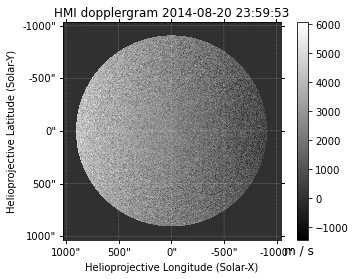

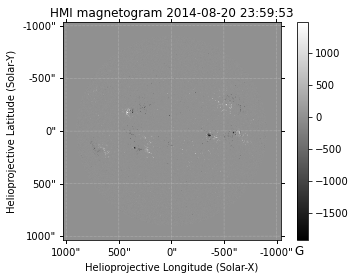

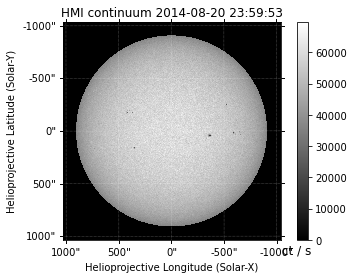

In [96]:
# coordinate transformation for maps
x, y, pdim, r, d, mu = ctfuncs.coordinates(vmap)
wij, nij, rij = ctfuncs.vel_coords(x, y, pdim, r, vmap)

# remove bad mu values
vmap, mmap, imap = ctfuncs.fix_mu(mu, [vmap, mmap, imap])

# quick peeks at the uncorrected images
vmap.peek()
mmap.peek()
imap.peek()



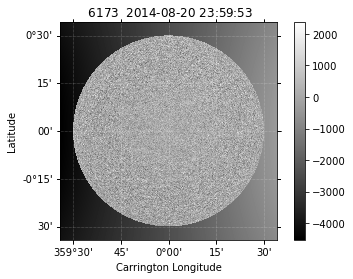

In [97]:
###### Velocity Corrections ######
# calculate relative positions
deltaw, deltan, deltar, dij = sfuncs.rel_positions(wij, nij, rij, vmap)

# calculate spacecraft velocity
vsc = sfuncs.spacecraft_vel(deltaw, deltan, deltar, dij, vmap)

# optimized solar rotation parameters
a_parameters = [Parameters.a1, Parameters.a2, Parameters.a3]

# calculation of solar rotation velocity
vrot = sfuncs.solar_rot_vel(wij, nij, rij, deltaw, deltan, deltar, dij, vmap, a_parameters)

# calculate corrected velocity
corrected_vel = vmap.data - np.real(vsc) - np.real(vrot)

# corrected velocity maps
map_vel_cor = sfuncs.corrected_map(corrected_vel, vmap, map_type='Corrected-Dopplergram',
                                               frame=frames.HeliographicCarrington)

map_vel_cor.peek()

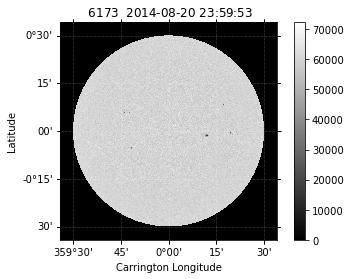

In [98]:
###### Limb Darkening Corrections ######
# limb brightening
Lij = lbfuncs.limb_polynomial(imap)

# calculate corrected data
Iflat = imap.data / Lij

# corrected intensity maps
map_int_cor = sfuncs.corrected_map(Iflat, imap, map_type='Corrected-Intensitygram',
                                               frame=frames.HeliographicCarrington)

map_int_cor.peek()


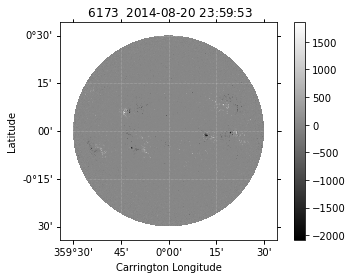

"mag_map = map_mag_cor\nmag_map.plot_settings['norm'] = plt.Normalize(-100, 100)\nmag_map.plot()\nplt.show()"

In [99]:
##### Magnetogram #####

# calculate unsigned field strength to correct for foreshortening 
Bobs, Br = sfuncs.mag_field(mu, mmap, B_noise=Parameters.B_noise, mu_cutoff=Parameters.mu_cutoff)

# corrected observed magnetic data map
map_mag_obs = sfuncs.corrected_map(Bobs, mmap, map_type='Corrected-Magnetogram',
                                               frame=frames.HeliographicCarrington)

# true radial magnetic data map
map_mag_cor = sfuncs.corrected_map(Br, mmap, map_type='Corrected-Magnetogram',
                                               frame=frames.HeliographicCarrington)

#map_mag_obs.peek()
map_mag_cor.peek()

# to see a bit better
'''mag_map = map_mag_cor
mag_map.plot_settings['norm'] = plt.Normalize(-100, 100)
mag_map.plot()
plt.show()'''

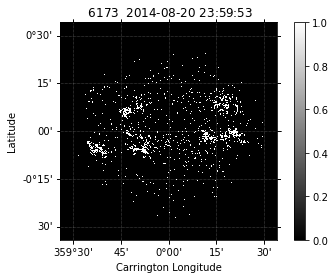

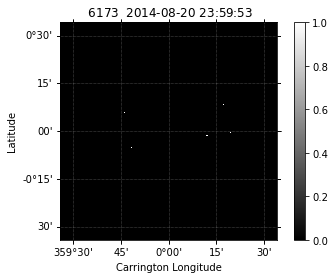

In [100]:
##### Find thresholds #####
# calculate magnetic threshold
#active, quiet = sfuncs.mag_thresh(mu, mmap, Br_cutoff=Parameters.Br_cutoff, mu_cutoff=Parameters.mu_cutoff)

active,quiet = sfuncs.mag_thresh(mu, mmap, Br_cutoff=Parameters.Br_cutoff, mu_cutoff=Parameters.mu_cutoff)

map_mag_thresh = sfuncs.corrected_map(active, mmap, map_type='Magnetic-Threshold',
                                                   frame=frames.HeliographicCarrington)
#map_mag_thresh.peek()



# calculate intensity threshold
fac_inds, spot_inds = sfuncs.int_thresh(map_int_cor, active, quiet)

# create faculae map objects
fac_map = sfuncs.corrected_map(fac_inds, mmap, map_type='Faculae', frame=frames.HeliographicCarrington)

# create sunspot map objects
spot_map = sfuncs.corrected_map(spot_inds, mmap, map_type='Sunspot', frame=frames.HeliographicCarrington)

fac_map.peek()
spot_map.peek()


# create threshold array
thresh_arr = sfuncs.thresh_map(fac_inds, spot_inds)

# full threshold maps
map_full_thresh = sfuncs.corrected_map(thresh_arr, mmap, map_type='Threshold',
                                                   frame=frames.HeliographicCarrington)



#map_full_thresh.peek()
#hmi_plot(map_int_cor, map_mag_obs, map_vel_cor, fac_inds, spot_inds, mu, save_fig=None)

In [116]:
##### Radial Velocity Computations in m/s #####
'''For more information refer to Haywood et al 2016 and Milbourne et al 2019'''


### velocity contribution due to convective motion of quiet-Sun
v_quiet = sfuncs.v_quiet(map_vel_cor, imap, quiet)

### velocity contribution due to rotational Doppler imbalance of active regions (faculae/sunspots)
# calculate photospheric velocity
v_phot, vphot_bright, vphot_spot = sfuncs.v_phot(quiet, active, Lij, vrot, imap, mu, fac_inds, spot_inds, mu_cutoff=Parameters.mu_cutoff)

### velocity contribution due to suppression of convective blueshift by active regions
# calculate disc-averaged velocity
v_disc = sfuncs.v_disc(map_vel_cor, imap)
# calculate convective velocity
v_conv = v_disc - v_quiet

print(f'Photmetric velocity: {v_phot:.2f} m/s')
print(f'Convective velocity: {v_conv:.2f} m/s')

if inst.startswith("H"):
    # HARPS-N values
    A = 2.101
    B = 0.9825
    RV0 = 97.08
if inst.startswith("N"):
    # NEID values
    A = 1.0983
    B = 1.423
    RV0 = -646.076
else:
    raise "Unknown instrument"

#rv_model = rvs.calc_model("HARPS-N", v_conv, v_phot)
rv_model = A * v_phot + B * v_conv

print(f'Derived radial velocity: {rv_model:.2f} m/s')

Photmetric velocity: 0.27 m/s
Convective velocity: 6.34 m/s
Derived radial velocity: 6.79 m/s


In [109]:
##### Compute filling factors
f_bright, f_spot, f = sfuncs.filling_factor(mu, mmap, active, fac_inds, spot_inds, mu_cutoff=Parameters.mu_cutoff)

print(f'Bright regions: {f_bright:.2f}%')
print(f'Spots: {f_spot:.2f}%')

### calculate the area filling factor
pixA_hem = ctfuncs.pix_area_hem(wij, nij, rij, vmap)
area = sfuncs.area_calc(active, pixA_hem)
f_small, f_large, f_network, f_plage = sfuncs.area_filling_factor(active, area, mu, mmap,
                                                                             fac_inds, athresh=Parameters.athresh,
                                                                             mu_cutoff=Parameters.mu_cutoff)

print(f'Plage/faculae regions: {f_plage:.2f}%')
print(f'Bright Network: {f_network:.2f}%')

Bright regions: 4.07%
Spots: 0.02%
Plage/faculae regions: 2.05%
Bright Network: 2.02%


In [119]:
### Unsigned Magnetic Flux

unsigned_obs_flux = sfuncs.unsigned_flux(map_mag_obs, imap)

quiet_flux, ar_flux, conv_flux, pol_flux, pol_conv_flux = sfuncs.area_unsigned_flux(map_mag_obs, imap,
                                                                                        area,
                                                                                        active,
                                                                                    athresh=Parameters.athresh)

### get area weighted convective velocities
vconv_quiet, vconv_large, vconv_small = sfuncs.area_vconv(map_vel_cor, imap, active, area, athresh=Parameters.athresh)

print(f'Unsigned Magnetic Flux: {unsigned_obs_flux:.2f} G')
print(f'Signed Magnetic Flux: {pol_flux:.2f} G')

Unsigned Magnetic Flux: 12.01 G
Signed Magnetic Flux: 0.12 G


In [137]:
# make dictionary of what we want to save
save_vals = {
    "rv_model":rv_model,
     "v_quiet":v_quiet,
     "v_disc":v_disc,
     "v_phot":v_phot,
     "v_conv":v_conv,
     "f_bright":f_bright,
     "f_spot":f_spot,
     "f":f,
     "unsigned_obs_flux":unsigned_obs_flux,
     "vphot_bright":vphot_bright,
     "vphot_spot":vphot_spot,
     "f_small":f_small,
     "f_large":f_large,
     "f_network":f_network,
     "f_plage":f_plage,
     "quiet_flux":quiet_flux,
     "ar_flux":ar_flux,
     "conv_flux":conv_flux,
     "pol_flux":pol_flux, 
     "pol_conv_flux":pol_conv_flux,
     "vconv_quiet":vconv_quiet,
     "vconv_large":vconv_large,
     "vconv_small":vconv_small
}


# save these values to the csv file
df = pd.concat((df,pd.DataFrame(save_vals, index=[0])))
df.to_csv(f'./{csv_name}.csv')
# print that the date is completed
print('\nCalculations and save to file complete')


Calculations and save to file complete
